In [14]:
import sys
sys.path.append('../')
from Model.model import ConvModel
import dgl, torch, os, yaml
import torch.nn as nn
from evaluation import baseline_model_generator
from collections import defaultdict
import numpy as np
import pickle
from settings import BASE_DIR, CONFIG_PATH
from evaluation.evaluation_metrics import mmr,hit_rate_precision, hit_rate_recall, rbo

model_config = load_config("../model_config.yml")

graphs, _ = dgl.load_graphs(f"../run_data/graph_files_subgraph/ecommerce_hetero_graph.dgl")
ecommerce_hetero_graph_subgraph = graphs[0]
git status

graphs, _ = dgl.load_graphs(f"../run_data/graph_files_subgraph/train_g.dgl")
train_g = graphs[0]

graphs, _ = dgl.load_graphs(f"../run_data/graph_files_subgraph/test_g.dgl")
test_g = graphs[0]

graphs, _ = dgl.load_graphs(f"../run_data/graph_files_subgraph/valid_g.dgl")
valid_g = graphs[0]

saved_model = torch.load(f"../run_data/graph_files_subgraph/trained_model.pth")

../model_config.yml


In [17]:
def get_ground_truth_recs(g):

    customers_test, products_test  = (g.edges(etype='orders'))
    test_rated_arr = np.stack((np.asarray(customers_test), np.asarray(products_test)), axis=1)
    test_rated_dict = defaultdict(list)
    
    for key, val in test_rated_arr:
        test_rated_dict[key].append(val)
    
    return {customer: list(set(products)) for customer, products in test_rated_dict.items()}

recommendations_from_valid_graph = get_ground_truth_recs(valid_g)

with open(f"../run_data/graph_files_subgraph/trained_embeddings.pickle", 'rb') as pickle_file:
    train_embeddings = pickle.load(pickle_file)

print(train_embeddings['customer'][1].shape, train_embeddings['customer'].shape, train_embeddings['product'].shape)

print('zeros count : ', (train_embeddings['product'][5].shape[0] - torch.count_nonzero(train_embeddings['product'][5])).item(), "out of",train_embeddings['product'][5].shape[0])

def get_model_recs():

    user_ids = valid_g.num_nodes('customer')
        
    recs = {}

    for user in range(user_ids):

        user_emb = train_embeddings['customer'][user]
        # user_emb_rpt = torch.cat(valid_g.num_nodes('product')*[user_emb]).reshape(-1, dim_dict['out_dim'])
        user_emb_rpt = user_emb.repeat(valid_g.num_nodes('product'), 1)

        # print("User embedding shape",y['product'].shape, user_emb_rpt.shape)
        cos = nn.CosineSimilarity(dim=1, eps=1e-6)
        ratings = cos(user_emb_rpt, train_embeddings['product'])
        
        ratings_formatted = ratings.detach().numpy().reshape(valid_g.num_nodes('product'),)
        order = np.argsort(-ratings_formatted)
        
        # already_rated = already_rated_dict[user]
        # order = [item for item in order if item not in already_rated]
        
        recs[user] = order
    
    return recs

# print(recs)

model_recommendations = get_model_recs()

print("Model recs length",len(model_recommendations))
print("Valid graph length",len(recommendations_from_valid_graph))

# use thif function to see actual recommendations
# print(compare_rec(recommendations_from_valid_graph, model_recommendations))


torch.Size([64]) torch.Size([96516, 64]) torch.Size([32171, 64])
zeros count :  64 out of 64
Model recs length 96516
Valid graph length 11231


In [5]:
random_model = baseline_model_generator.generate_random_model(ecommerce_hetero_graph_subgraph, 'customer', 'product')
baseline_model = baseline_model_generator.generate_popularity_model(ecommerce_hetero_graph_subgraph, 'orders', 'customer')


In [18]:
#Run 100 times
print("MMR Popular: ", mmr(recommendations_from_valid_graph, baseline_model, 1))
print("MMR Random: ", mmr(recommendations_from_valid_graph, random_model, 1))
print("MMR GNN Model: ", mmr(recommendations_from_valid_graph, model_recommendations, 1))

MMR Baseline:  0.015443635096361805
MMR Random:  0.00032921258526424804
MMR GNN Model:  0.15425457997250844


In [42]:
from evaluation.evaluation_metrics import mmr,hit_rate_precision, hit_rate_recall, rbo
import matplotlib.pyplot as plt
import random

In [19]:
thresholds = [5,10,15,20,25,30,35,40,45,50]

hit_rates_prec_baseline = []
hit_rates_prec_random = []
hit_rates_prec_model = []

hit_rates_recall_baseline = []
hit_rates_recall_random = []
hit_rates_recall_model = []

for t in thresholds:
    hit_rates_prec_baseline.append(hit_rate_precision(recommendations_from_valid_graph, baseline_model, t))
    hit_rates_prec_random.append(hit_rate_precision(recommendations_from_valid_graph, random_model, t))
    hit_rates_prec_model.append(hit_rate_precision(recommendations_from_valid_graph, model_recommendations, t))
    hit_rates_recall_baseline.append(hit_rate_recall(recommendations_from_valid_graph, baseline_model, t))
    hit_rates_recall_random.append(hit_rate_recall(recommendations_from_valid_graph, random_model, t))
    hit_rates_recall_model.append(hit_rate_recall(recommendations_from_valid_graph, model_recommendations, t))

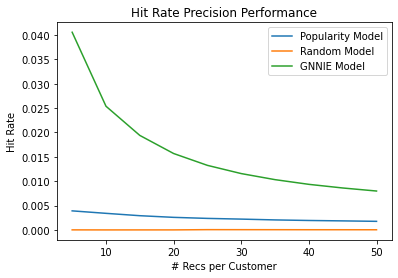

In [20]:
plt.plot(thresholds,hit_rates_prec_baseline, label = "Popularity Model")
plt.plot(thresholds,hit_rates_prec_random, label = "Random Model")
plt.plot(thresholds,hit_rates_prec_model, label = "GNNIE Model")
plt.legend()
plt.xlabel("# Recs per Customer")
plt.ylabel("Hit Rate")
plt.title("Hit Rate Precision Performance")
plt.show()



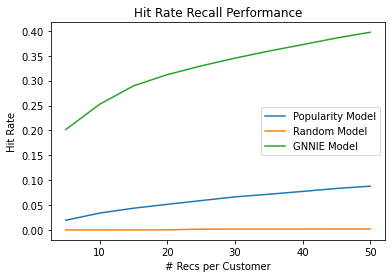

In [21]:
plt.plot(thresholds,hit_rates_recall_baseline, label = "Popularity Model")
plt.plot(thresholds,hit_rates_recall_random, label = "Random Model")
plt.plot(thresholds,hit_rates_recall_model, label = "GNNIE Model")
plt.legend()
plt.xlabel("# Recs per Customer")
plt.ylabel("Hit Rate")
plt.title("Hit Rate Recall Performance")
plt.show()

## RBO Analysis

In [67]:
# Sanity check
rbo(baseline_model[0][0:100],baseline_model[0][0:100])

0.9999999999999996

In [77]:
# Popular vs. Random
rbo_scores_5 = []
rbo_scores_15 = []
rbo_scores_30 = []

recs_sample = random.sample(list(model_recommendations.items()), 2000)

for i in range(0,len(recs_sample)):
    rbo_scores_5.append(rbo(baseline_model[0][0:100],random.sample(list(random_model[0]), 100),0.76))
    rbo_scores_15.append(rbo(baseline_model[0][0:100],random.sample(list(random_model[0]), 100),0.9165))
    rbo_scores_30.append(rbo(baseline_model[0][0:100],random.sample(list(random_model[0]), 100),0.9578))

In [78]:
print("Random-Popularity RBO giving 90% weight to first 5 recs: ", sum(rbo_scores_5) / len(rbo_scores_5))
print("Random-Popularity RBO giving 90% weight to first 15 recs: ", sum(rbo_scores_15) / len(rbo_scores_15))
print("Random-Popularity RBO giving 90% weight to first 30 recs: ", sum(rbo_scores_30) / len(rbo_scores_30))

Random-Popularity RBO giving 90% weight to first 5 recs:  0.00017267958964257974
Random-Popularity RBO giving 90% weight to first 15 recs:  0.00047695856967776827
Random-Popularity RBO giving 90% weight to first 30 recs:  0.0006727054905783503


In [79]:
# Popular vs. GNNIE
rbo_scores_5 = []
rbo_scores_15 = []
rbo_scores_30 = []

recs_sample = random.sample(list(model_recommendations.items()), 2000)

for i in range(0,len(recs_sample)):
    rbo_scores_5.append(rbo(baseline_model[0][0:100],recs_sample[i][1][0:100],0.76))
    rbo_scores_15.append(rbo(baseline_model[0][0:100],recs_sample[i][1][0:100],0.9165))
    rbo_scores_30.append(rbo(baseline_model[0][0:100],recs_sample[i][1][0:100],0.9578))

In [80]:
print("GNNIE-Popularity RBO giving 90% weight to first 5 recs: ", sum(rbo_scores_5) / len(rbo_scores_5))
print("GNNIE-Popularity RBO giving 90% weight to first 15 recs: ", sum(rbo_scores_15) / len(rbo_scores_15))
print("GNNIE-Popularity RBO giving 90% weight to first 30 recs: ", sum(rbo_scores_30) / len(rbo_scores_30))

GNNIE-Popularity RBO giving 90% weight to first 5 recs:  0.0009468491112156215
GNNIE-Popularity RBO giving 90% weight to first 15 recs:  0.0014589431482636968
GNNIE-Popularity RBO giving 90% weight to first 30 recs:  0.0020968307797631417
